In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

from scipy.sparse import hstack

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
import unicodedata  
from nltk import sent_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from better_profanity import profanity

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_recall_fscore_support,precision_score,recall_score,f1_score
import random
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

plt.style.use('ggplot')

def randomised_search_cv(classifier,parameters,df,col_list,labels,num_iter=500):
    accuracy_list = []
    RSEED = 42
    for i in range(num_iter):
        
        if i%(num_iter/4)==0:
            print(str(i)+"iterations ran")

        param_iter = {}
        for key,value in parameters.items():
            param_iter[key] = random.choice(value)
        clf = classifier(random_state=RSEED, **param_iter)

        scores = cross_val_score(clf, df[col_list], labels, cv=5,scoring="f1")
        accuracy_list += [(param_iter, np.mean(scores))]

    accuracy_list.sort(key = lambda x: x[1])
    print(accuracy_list[-1])
    return accuracy_list[-1]

def generate_prc(y_true, y_proba):
    return precision_recall_curve(y_true, y_proba[:, 1])

def plot_curves(clf_curves, ctype='roc', legend=False):
    clfs = clf_curves.keys()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    for clf, curve in clf_curves.items():
        if ctype == 'roc':
            x = curve[0]
            y = curve[1]
            xlabel = 'False Positive Rate'
            ylabel = 'True Positive Rate'
            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        if ctype == 'prc':
            x = curve[1]
            y = curve[0]
            xlabel = 'Recall'
            ylabel = 'Precision'
        if 'all' in clf:
            ax.plot(x, y, lw=3, color='k', label='%s AUC: %.4f' % (clf, auc(x, y)))
        else:
            ax.plot(x, y, lw=2, alpha=0.5, label='%s AUC: %.4f' % (clf, auc(x, y)))
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if legend:
        ax.legend(loc='best', fontsize=10)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_yticks(np.linspace(0, 1, 11))
    
    
def modelbuilder(classifier,parameters,train_data,test_data,col_list,train_labels,test_labels,title):
    clf = classifier(**parameters)
    trained_model = clf.fit(train_data[col_list], train_labels)
    print("Precision on train",precision_score(train_labels,clf.predict(train_data[col_list])) )
    print("Recall on train",recall_score(train_labels,clf.predict(train_data[col_list])) )
    print("F1 score on train",f1_score(train_labels,clf.predict(train_data[col_list])) )
#     params = {"verbose":0}
    
#     trained_model.set_params(**parameters)
    y_pred = clf.predict_proba(test_data[col_list])
    inc_prc = generate_prc(test_labels, y_pred)
    plot_curves({title: inc_prc}, ctype='prc', legend=True)
    y_predicted = clf.predict(test_data[col_list])
    prec_score= precision_score(test_labels,y_predicted)
    rec_score= recall_score(test_labels,y_predicted)
    f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
    print("Precision on test:",prec_score)
    print("Recall on test:",rec_score)
    print("F1 Score on test: ",f1)
    print(confusion_matrix(test_labels, y_predicted))
#     holdout_df = holdout_df.copy()
#     holdout_df['is_promoted'] = clf.predict(holdout_df[col_list])
#     holdout_df[['employee_id','is_promoted']].to_csv("../submissions/"+title+".csv",index=False)

In [3]:
train = pd.read_csv("../datasets/train.csv")
game_overview = pd.read_csv("../datasets/game_overview.csv")

#### Text Preprocessing

In [4]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        new_word = re.sub(r'(.)\1+', r'\1\1', new_word) 
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = stopwords.words('english')
#     stop_words.append(uniquevalues)
    new_words = [x for x in words if x not in stop_words]
    return new_words

def remove_small_words(words,len_not_all=2):
    return [word for word in words if len(word)>len_not_all]


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in words ]
    return lemmas

def remove_urls(TEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', TEXT, flags=re.MULTILINE)
    return(vTEXT)

def add_space_before_cap_I(text):
    return re.sub("I"," I",text)

def add_space_after_full_stop(text):
    return re.sub("\.",". ",text)

def remove_curse_words(text):
    return profanity.censor(text, '-')

def remove_numbers(text):
    return re.sub("\d+"," ",text)

def replace_heart_emoji_with_pos(text):
    return re.sub("♥"," <heart emoji> ",text)

In [5]:
def preprocess2(text):
    new_text  = remove_urls(text)
    new_text1 = remove_numbers(new_text)
    new_text2 = add_space_after_full_stop(new_text1)
    new_text3 = add_space_before_cap_I(new_text2)
    new_text4 = remove_curse_words(new_text3)
    new_text5 = replace_heart_emoji_with_pos(new_text4)
    content = nltk.word_tokenize(new_text5)
    words = remove_non_ascii(content)
    words = to_lowercase(words)
    words = lemmatize_verbs(words)
#     words = remove_stopwords(words)
    words = remove_small_words(words)
#     words = lemmatize_verbs(words)
    words = remove_punctuation(words)
    text = ' '.join(words)
    return text

In [6]:
train['new_user_review'] = train['user_review'].apply(preprocess2)

In [7]:
train['no_of_words'] = train['new_user_review'].apply(lambda x: len(x.split()))

In [8]:
train[train['no_of_words']==0].tail()

,review_id,title,year,user_review,user_suggestion,new_user_review,no_of_words
14342,20669,Shop Heroes,2016.0,░░░░░░░░░░░████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░███░██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░██░░░█░░░░░░░░░░░...,1,,0
15302,22413,Business Tour - Board Game with Online Multiplayer,2017.0,░░░░░░░░░░░░▄▄░░░░░░░░░ ░░░░░░░░░░░█░░█░░░░░░░░ ░░░░░░░░░░░█░░█░░░░░░░░ ░░░░░░░░░░█░░░█░░░░░░░░ ...,1,,0
16333,24193,World of Guns: Gun Disassembly,2017.0,https://www.youtube.com/watch?v=iHohinK5e9shttps://www.youtube.com/watch?v=iHohinK5e9shttps://ww...,1,,0
16568,24537,Bloons TD Battles,2017.0,░░░░░░░░░░░░░██ ░░░░░░░░░░░░█░░█ ░░░░░░░░░░░░█░░█ ░░░░░░░░░░░█░░░█ ░░░░░░░░░░█░░░░█ ████████▄▄█░...,1,,0
17170,25216,School of Dragons,2018.0,Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â ...,1,,0


In [9]:
train['no_of_words'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count    17494.000000
mean       109.086658
std        129.455439
min          0.000000
1%          21.000000
10%         30.000000
25%         40.000000
50%         65.000000
75%        122.000000
90%        231.000000
95%        341.000000
99%        680.070000
max       2040.000000
Name: no_of_words, dtype: float64

We can see that processed review with length 0 are the junk review and doesn't help much and we can assign ambiguous keywords like "recommend" and "not recommend" depending on the target class

In [10]:
def plot_wordcloud(train, sent, col):
    reviews = train[train['user_suggestion']==sent][col].str.cat(sep=' ')
    #function to split text into word
    tokens = word_tokenize(reviews)
    vocabulary = set(tokens)
    frequency_dist = nltk.FreqDist(tokens)
    wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

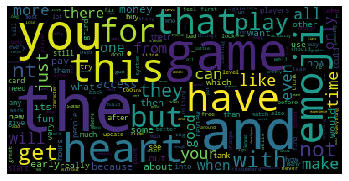

In [11]:
plot_wordcloud(train, 0, 'new_user_review')

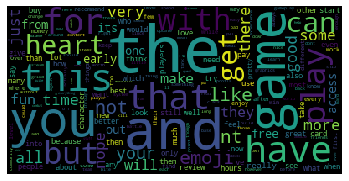

In [12]:
plot_wordcloud(train, 1, 'new_user_review')

In [29]:
train[train['no_of_words']==0]

,review_id,title,year,user_review,user_suggestion,new_user_review,no_of_words,new_user_review2
190,191,Spooky's Jump Scare Mansion,2017.0,░░░░░░░░░░░░▄▐ ░░░░░░░░░░░▄██▄ ░░░░░( ͡° ͜ʖ ͡°)░░░░░▀█▄ ░░░░░░░░░░░░░░░░▀█ ░░░░▄▄▄██▀▀▀▀▄▄▄▄▄▀▀ ...,1,,0,1
215,216,Spooky's Jump Scare Mansion,2017.0,░░░░░░░░░░░░░░░░░░░░░░█████████░░███████░░░░░░░░░░███▒▒▒▒▒▒▒▒███░░█▒▒▒▒▒▒█░░░░░░░███▒▒▒▒▒▒▒▒▒▒▒▒...,1,,0,1
438,439,Sakura Clicker,2015.0,( ͡° ͜ʖ ͡°)( ͡° ͜ʖ ͡°)( ͡° ͜ʖ ͡°)( ͡° ͜ʖ ͡°)( ͡° ͜ʖ ͡°)( ͡° ͜ʖ ͡°)( ͡° ͜ʖ ͡°)( ͡° ͜ʖ ͡°)( ͡° ͜ʖ ...,1,,0,1
1672,2136,Dota 2,2014.0,"Я считаю что дота вполне отличная игра. Отличный геймплей, графика, музыка, радует донат который...",1,,0,1
1729,2193,Dota 2,2014.0,"Заходите значит вы такие в туалет,подходите к унитазу и видете такую картину : весь толчок залит...",1,,0,1
1899,2363,Dota 2,2016.0,Отличный геймплей. Удовольствие от каждой завершенной игры. Качественный подбор игроков. Дружелю...,1,,0,1
2777,3241,War Thunder,2018.0,███████████████───█─██─█───███─██─██─█─█████─██────█───███─██─██─█─█████─██─██─█───█████████████...,1,,0,1
3662,4126,Team Fortress 2,2015.0,────────────────────░███░───────────────────░█░░░█░──────────────────░█░░░░░█░─────────────────░...,1,,0,1
3869,4333,Team Fortress 2,2016.0,"Шикарнейшая игра, шутер с огромным количеством проработаных карт и режимов, своеобразной кастоми...",1,,0,1
4035,4499,Team Fortress 2,2017.0,"За те деньги , что ты сюда вложил ты мог купить овервотч и получать удовольствие от игры вместо...",1,,0,1
